Importation des librairies


In [21]:
import numpy as np

In [22]:
t =np.array([[-1, 0, 0, 8], [0, -1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])
t_inv = invert_matrix( t)
t 

array([[-1,  0,  0,  8],
       [ 0, -1,  0,  0],
       [ 0,  0,  1,  0],
       [ 0,  0,  0,  1]])

In [23]:
t_inv

array([[-1., -0., -0.,  8.],
       [-0., -1., -0., -0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  1.]])

Class de definition de repère

In [24]:
# Calculer l'inverse d'une matrice 

def invert_matrix(mat):
    """
    Retourne l'inverse de `mat` ou lève une exception si non inversible.
    """
    try:
        return np.linalg.inv(mat)
    except np.linalg.LinAlgError:
        raise ValueError("Matrice singulière : impossible d'appliquer l'inverse.")


# Classe représentant un repère local dans un espace 3D
class RepereLocal:
    def __init__(self, origine, rotation_matrix=None, nom=None):
        self.origine = np.array(origine)  # Position du repère dans W
        # Matrice de rotation 3x3 (identité si non spécifiée)
        self.rotation = rotation_matrix if rotation_matrix is not None else np.eye(3)
        self.nom = "nom" if nom is not None else "Repère Local"
        self.i = np.array([1, 0, 0]) @ self.rotation
        self.j = np.array([0, 1, 0]) @ self.rotation
        self.k = np.array([0, 0, 1]) @ self.rotation



    def get_transform_matrixs(self):
        """Retourne la matrice de transformation homogène 4x4"""
        T = np.eye(4)
        T[0:3, 0:3] = self.rotation
        T[0:3, 3] = self.origine
        T_inv = invert_matrix(T)
        return [ T , T_inv]

    



In [ ]:
def transform_point_RA_to_RB(point_RA, repere_B):
        point = point_RA
        [ T , T_inv]= repere_B.get_transform_matrixs()
        point_in_C = T_inv @ point
    
        return point_in_C


In [26]:
# 1. Définir le repère monde W (repère de référence global)
Repere_W = RepereLocal(origine=[0, 0, 0], nom="Repère W")


In [27]:
Repere_C = RepereLocal(origine=[0, 16, 0], rotation_matrix=np.array([[0,1,0],
                                                                    [0, 0, -1],
                                                                    [-1, 0, 0]]),
                                                                    nom="Repère C")
Repere_C.get_transform_matrixs()
Repere_C.i

array([0, 1, 0])

In [28]:
[ T , T_inv]= Repere_C.get_transform_matrixs()


In [29]:
z_camera = np.array([0, 0, 1,0]) @ T_inv # Vecteur unitaire de l'axe Z du repère caméra
z_camera

array([ 0., -1.,  0., 16.])

C:\Users\justi\AppData\Local\Temp\ipykernel_1668\2971926231.py:62: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


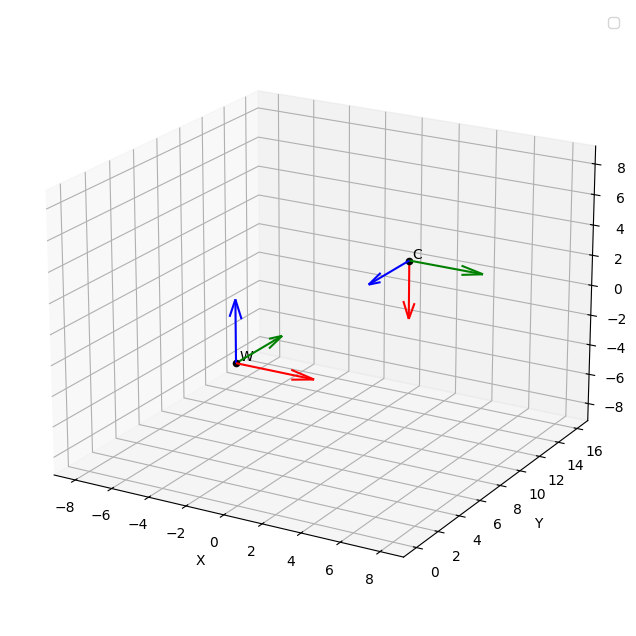

In [30]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # registers 3D projection

def plot_repere(ax, repere, length=3.0, label=None):
    """
    Trace un repère (origine + axes i,j,k) sur l'axe 3D `ax`.
    `repere` doit fournir `origine` (3,) et `rotation` (3x3).
    """
    origin = np.asarray(repere.origine).ravel()[:3]
    R = np.asarray(repere.rotation)
    # axes dans le repère monde : colonnes de R (R @ e_i)
    i_axis = R @ np.array([1., 0., 0.])
    j_axis = R @ np.array([0., 1., 0.])
    k_axis = R @ np.array([0., 0., 1.])
    ax.quiver(*origin, *i_axis, length=length, color='r', normalize=True)
    ax.quiver(*origin, *j_axis, length=length, color='g', normalize=True)
    ax.quiver(*origin, *k_axis, length=length, color='b', normalize=True)
    ax.scatter(*origin, color='k', s=20)
    if label:
        ax.text(*(origin + 0.1), label, color='k')

def set_axes_equal(ax):
    """Fixe un ratio égal pour les axes 3D."""
    limits = np.array([ax.get_xlim3d(), ax.get_ylim3d(), ax.get_zlim3d()])
    mins = limits[:,0]
    maxs = limits[:,1]
    centers = 0.5 * (mins + maxs)
    spans = maxs - mins
    radius = 0.5 * max(spans)
    ax.set_xlim3d(centers[0] - radius, centers[0] + radius)
    ax.set_ylim3d(centers[1] - radius, centers[1] + radius)
    ax.set_zlim3d(centers[2] - radius, centers[2] + radius)

# Tracer les repères existants
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
plot_repere(ax, Repere_W, length=4, label='W')
plot_repere(ax, Repere_C, length=4, label='C')

# si Camera1.R_camera existe, le tracer aussi
try:
    cam_rep = Camera1.R_camera
    plot_repere(ax, cam_rep, length=4, label='Camera')
except NameError:
    pass

# Optionnel : tracer le point étudié en monde et sa projection dans C (si définis)
try:
    ax.scatter(*point_w[:3].ravel(), color='m', s=30, label='point_w')
except NameError:
    pass
try:
    ax.scatter(*point_C[:3].ravel(), color='c', s=30, label='point_C')
except NameError:
    pass

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.view_init(elev=20, azim=-60)
set_axes_equal(ax)
ax.legend()
plt.show()

In [31]:
point_w = np.array([-2.25,11,1.5,1]).reshape(4,1)
#point.reshape(4,1)

In [32]:
point_C = transform_point_RA_to_RB(point_w, Repere_C)

point_C

array([[-1.5 ],
       [-2.25],
       [ 5.  ],
       [ 1.  ]])

In [33]:

class Camera:
    
    
    def __init__(self, K, R_camera=None):

        self.K = K  # Matrice intrinsèque
        self.R_camera = R_camera if R_camera is not None else np.eye(4)  # Rotation (identité par défaut)
        #self.t = t if t is not None else np.zeros((3, 1))  # Translation (zéro par défaut)
    
    
    
    def camera_vers_image(self, point_RC):
        point_RC = point_RC.reshape(3, 1) if point_RC.ndim == 1 else point_RC
        
        # Projection perspective
        point_image_RE = self.K @ point_RC
        
        # Conversion en coordonnées inhomogènes
        point_image_RE = np.round(point_image_RE[:2] / point_image_RE[2])

        return point_image_RE.flatten()
    
    






In [34]:
H = 480  # Hauteur de l'image en pixels
W = 640  # Largeur de l'image en pixels
origin_I = [H/2, W/2, 0]
fx = 800
fy = 800
s = 0
cx = W/2      
cy = H/2     


K = np.array([[-fx, s, cx],
             [0, -fy, cy],   
             [0,  0,    1]])    

R_camera =  RepereLocal(origine=[-16, 16, 20], rotation_matrix=np.array([[1/np.sqrt(2), 0.5, 0.5],
                                                                        [1/np.sqrt(2), -0.5, -0.5],
                                                                        [0., 1/np.sqrt(2), -1/np.sqrt(2)]]),
                                                                        nom="Repère Camera")

Camera1 = Camera(K, R_camera)   

In [35]:
point_C[0:3]

array([[-1.5 ],
       [-2.25],
       [ 5.  ]])

In [36]:
point_RE = Camera1.camera_vers_image(point_C[0:3])  # point_w en coordonnées homogènes
point_RE


array([560., 600.])

In [37]:
# angle = np.radians(45)
# rotation_C = np.array([
#     [np.cos(angle), -np.sin(angle), 0],
#     [np.sin(angle), np.cos(angle), 0],
#     [0, 0, 1]
# ])